## ARIMA Modell anlernen am Beispiel der Oracle-Aktiendaten

### TEIL I: Vorbereitung der Daten, Prüfung der Hyperparameter und Anlernen des Modells (Kapitel 4.5.1)

#### 1) Daten laden und Datumsindex setzen

In [1]:
import pandas as pd
from math import ceil

pd.set_option('display.max_columns', 6)

data_url=r'https://github.com/tplusone/hanser_ml_zeitreihen/blob/master/Daten/oracle_monthly.csv?raw=true'
df = pd.read_csv(data_url)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.index.freq = 'M'
df.head()

,Open,High,Low,Close,Volume,OpenInt
date,,,,,,
1988-03-31,0.182163,0.186745,0.177997,0.182989,4.200000e+07,0.0
1988-04-30,0.179695,0.183355,0.176047,0.180160,2.411046e+07,0.0
1988-05-31,0.186024,0.191254,0.181214,0.185144,2.427022e+07,0.0
1988-06-30,0.209717,0.214749,0.207627,0.211388,4.139041e+07,0.0
1988-07-31,0.226603,0.231207,0.219703,0.225671,4.044477e+07,0.0


#### 2) Preprocessing I: logarithmieren und first differences berechnen

<AxesSubplot:xlabel='date'>

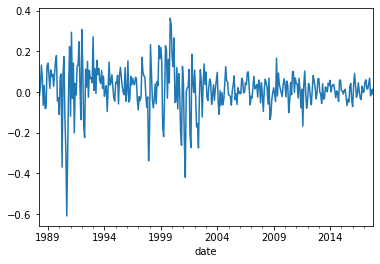

In [2]:
import numpy as np
df['close_log'] = np.log(df['Close'])
df['log_diff'] = df['close_log'].diff(periods=1)
df['log_diff'].plot()

#### 3) Preprocessing II: Autokorrelations- und partielle Autokorrelationsdiagramme prüfen

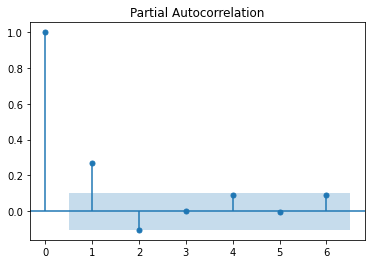

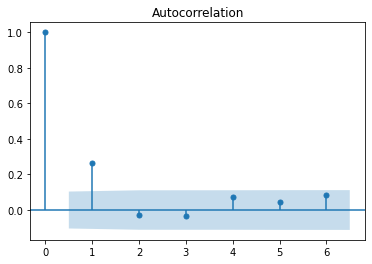

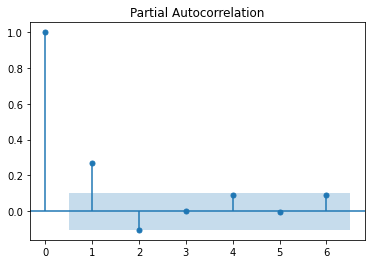

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['log_diff'].dropna(), lags=6)
plot_pacf(df['log_diff'].dropna(), lags=6)

#### 4) Preprocessing III: Train-Test-Split

In [4]:
from math import ceil

end_train = ceil(len(df) * 0.9)
df_train = df.iloc[:end_train]
df_test = df.iloc[end_train:]
len(df_train), len(df_test)

(322, 35)

#### 5) ARIMA-Modell aufbauen und anlernen

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_train['close_log'] = np.log(df_train['Close'])
arima = SARIMAX(df_train['close_log'], order=(0,1,1))
result = arima.fit()
result.summary()

C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              close_log   No. Observations:                  322
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 262.499
Date:                Tue, 08 Sep 2020   AIC                           -520.997
Time:                        14:58:07   BIC                           -513.454
Sample:                    03-31-1988   HQIC                          -517.985
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2957      0.041      7.236      0.000       0.216       0.376
sigma2         0.0114      0.001     20.209      0.000       0.010       0.013
===================================================================================
Ljung-Box (Q):                       48.82   Jarque-Bera (JB):               193.30
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 6) Vorhersagen mit predict- und forecast-Methode
##### predict-Methode

<b>Hinweis:</b> Die predict-Methode verwendet die hinterlegten Daten für den Zeitraum, für den noch Daten vorliegen als Grundlage der Schätzung. Werden Prognosen in die Zukunft gestellt, kann auf keine Updates aus dem Vormonat mehr zugegriffen werden. Dadurch entsteht die gerade Schätzlinie (vgl. unten ab Januar 2015 - Ende der Trainingsdaten)

<AxesSubplot:>

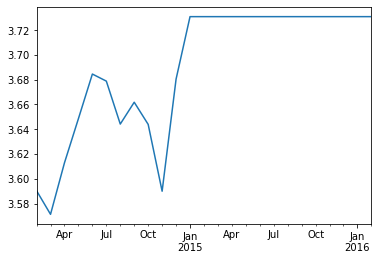

In [6]:
pred_dt0214_0216 = result.predict(start='2014-2', end='2016-02')
pred_dt0214_0216.plot()

##### forecast-Methode

In [7]:
result.forecast(1)

2015-01-31    3.730855
Freq: M, dtype: float64

### TEIL II: Evaluation anhand der Testdaten (Kapitel 4.5.2)

#### 1) Modell mit Testdaten versorgen, um Schätzungen mit Updates durchführen zu können

<AxesSubplot:xlabel='date'>

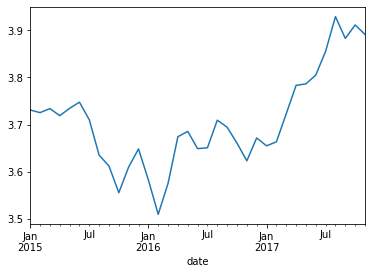

In [8]:
model = SARIMAX(df['close_log'], order=(0,1,1))
result_new = model.filter(result.params)

y_pred_test = result_new.predict(start='2015-01-31')
y_pred_test.plot()

#### 2) Schätzwerte "entlogarithmieren"

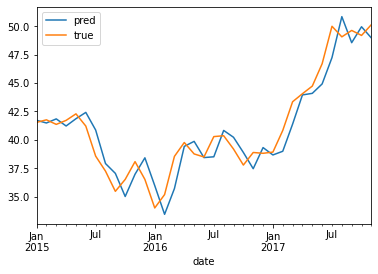

In [9]:
import matplotlib.pyplot as plt
import numpy as np
y_pred_test_exp = np.exp(y_pred_test)
y_pred_test_exp.plot(label='pred')
df_test['Close'].plot(label='true')
plt.legend()

#### 3) Baseline-Modell erzeugen

In [10]:
y_pred_simple = df_test['Close'].iloc[:-1]
y_pred_simple = y_pred_simple.append(df_train['Close'].iloc[-1:])
y_pred_simple = y_pred_simple.sort_index().tolist()
y_pred_simple[:5]

[41.237590909090905,
 41.53069999999999,
 41.75500000000001,
 41.354136363636364,
 41.70590476190475]

####  4) Leistung des ARIMA- im Vergleich zum Baseline-Modell prüfen

In [11]:
import numpy as np
mae_arima = np.mean(np.abs(df_test['Close'] - y_pred_test_exp))
mse_arima = np.mean(np.square(df_test['Close'] - y_pred_test_exp))
mae_simple = np.mean(np.abs(df_test['Close'] - y_pred_simple))
mse_simple = np.mean(np.square(df_test['Close'] - y_pred_simple))

print('Mean absolute Error (mae) / Mean squared Error (mse)')
print('ARIMA - mae: {:.3f}, mse: {:.3f}'.format(mae_arima, mse_arima))
print('Baseline - mae {:.3f}, mse {:.3f}'.format(mae_simple, mse_simple))

Mean absolute Error (mae) / Mean squared Error (mse)
ARIMA - mae: 1.161, mse: 1.902
Baseline - mae 1.203, mse 2.208
